In [1]:
import pandas as pd 
import numpy as np
import networkx as nx
from chembl_webresource_client.new_client import new_client
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
#read ppi network
G = nx.from_pandas_edgelist(pd.read_csv('data/Gene_Gene.csv'), 'source', 'target')

In [3]:
#read chemical bioactivity records
path = '/Users/f.nasirian/Dropbox (CCNR)/Biology/99_Toolbox/data/'
act = pd.read_csv(path+'Bioactivities/data/out/bioactivities.csv')

In [4]:
#will use chemical formula for validation 
gooseberry = {'Geraniin': 'C41H28O27',
 'Kaempferol': 'C15H10O6',
 'Quercetin': 'C15H10O7', 
 'Pyrogallol': 'C6H6O3', 
 'Gallic acid': 'C7H6O5',
 'Citric acid': 'C6H8O7', 
 'Ascorbic acid': 'C6H8O6', 
 'Ellagic acid': 'C14H6O8',
 'Chebulic acid': 'C14H12O11', 
 'Chebulinic acid': 'C41H32O27', 
 'Corilagin': 'C27H22O18', 
 'Emblicanin B': 'C34H20O22', 
 'Emblicanin A': 'C34H22O22', 
 'Pedunculagin': 'C34H24O22'}

In [5]:
len(gooseberry)

14

In [6]:
_df = pd.DataFrame(list(gooseberry.keys()), columns=['chemName'])

Check [this](https://github.com/chembl/chembl_webresource_client/blob/master/demo_wrc.ipynb) to learn how to query chemicals' data in ChEMBL. 

In [7]:
molecule = new_client.molecule 

In [8]:
#use iexact as the lookup type to get case-insensitive exact match (map chemical name to chembl id)
def f(x):
    temp_dict = molecule.filter(pref_name__iexact=x).only(['molecule_chembl_id', 'molecule_properties'])[0]
    if temp_dict:
        if temp_dict['molecule_properties']['full_molformula'] == gooseberry[x]:
            return(temp_dict['molecule_chembl_id']) 
        else:
            return(np.nan)

_df['chemId'] = _df.chemName.apply(lambda x: f(x))

In [9]:
_df = _df[_df.chemId.notnull()]

In [10]:
id_name = dict(zip(_df.chemId, _df.chemName))

In [11]:
#pass to michael for AI-bind prediction
_df.to_csv('data/Gooseberry_chemical_list.csv', index=False)

### Experimentally validated targets

In [12]:
v1 = act[['chemId', 'GeneId']]
v1['version'] = 'v1'

In [13]:
v2 = pd.read_csv('data/chemical_target_db.csv')
v2['version'] = 'v2'

In [14]:
gb_act = pd.concat([v1, v2])

In [15]:
gb_act = gb_act[gb_act.GeneId.isin(G.nodes())]

In [16]:
#add targets
_df = _df.merge(gb_act, on='chemId', how='left')
_df = _df[_df.GeneId.notnull()]

In [17]:
#chemical-target count
_df.drop('version', axis=1).drop_duplicates().groupby('chemName')['GeneId'].size() 

chemName
Ascorbic acid    29
Citric acid      15
Corilagin         1
Ellagic acid     45
Gallic acid       5
Kaempferol       16
Pedunculagin      1
Pyrogallol        5
Quercetin        66
Name: GeneId, dtype: int64

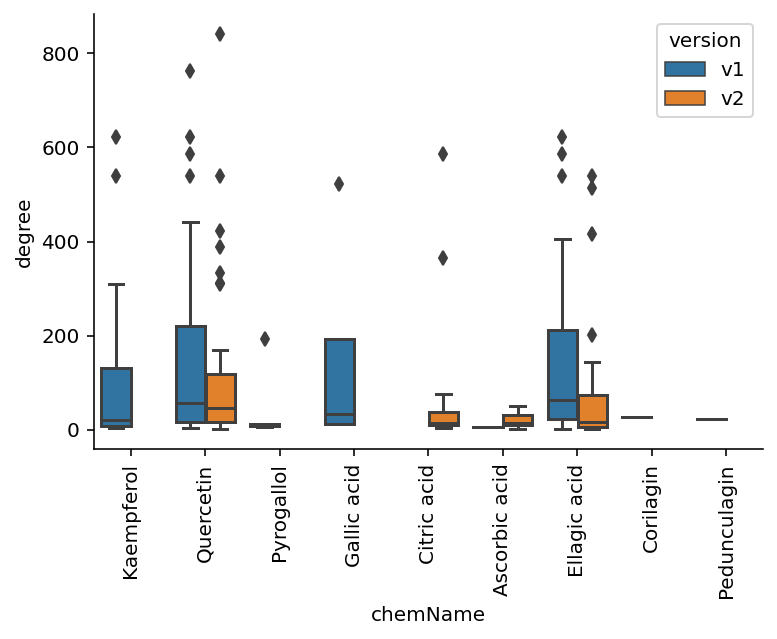

In [18]:
temp = _df.copy()
temp['degree'] = _df.GeneId.apply(lambda x: list(G.degree([x]))[0][1])
sns.boxplot(data=temp, x='chemName', y='degree', hue='version')
plt.xticks(rotation = 90)
sns.despine()

In [19]:
_df.to_csv('data/chemical_target_both_version.csv', index=False)

In [20]:
_df = _df.drop('version', axis=1).drop_duplicates()

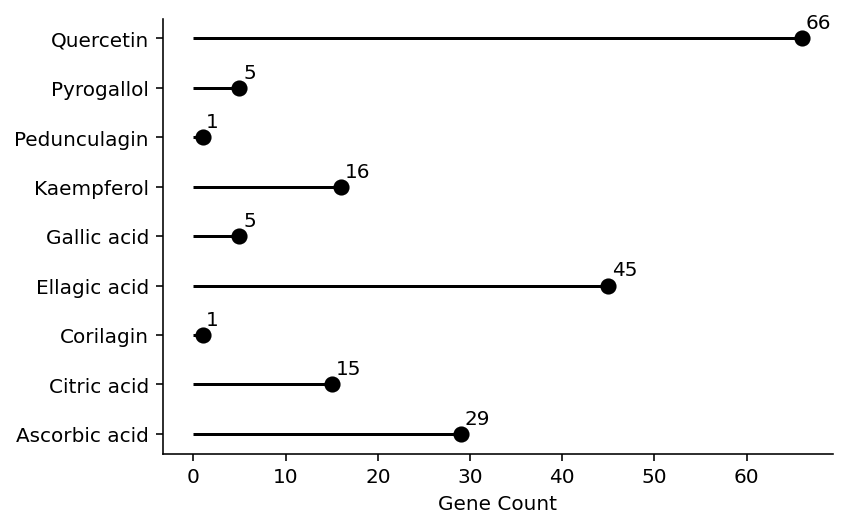

In [21]:
data = _df.groupby('chemName')['GeneId'].size().reset_index()

plt.scatter(x=data.GeneId, y=data.chemName, color='black', s=50)
plt.hlines(xmin=0, xmax=data.GeneId, y=data.chemName, color='black')
for i in data.index:
    plt.text(data.at[i, 'GeneId']+0.4, i+0.2, np.round(data.at[i, 'GeneId'],2))
plt.xlabel('Gene Count')
sns.despine()
plt.savefig('data/chemical_gene_count.svg', bbox_inches='tight')

In [22]:
#common targets
df = _df.GeneId.value_counts().reset_index()

In [23]:
df['degree'] = df['index'].apply(lambda x: list(G.degree([x]))[0][1])

c:\Users\f.nasirian\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 39.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\f.nasirian\Anaconda3\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


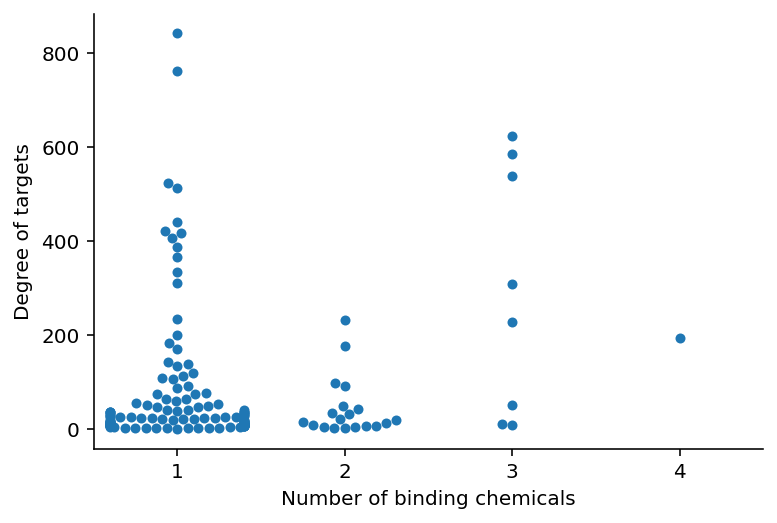

In [24]:
sns.swarmplot(data=df, x='GeneId', y='degree')
plt.xlabel('Number of binding chemicals')
plt.ylabel('Degree of targets')
sns.despine()

In [25]:
_df[_df.GeneId == 'HSD17B10']

,chemName,chemId,GeneId
39,Quercetin,CHEMBL50,HSD17B10
89,Pyrogallol,CHEMBL307145,HSD17B10
97,Gallic acid,CHEMBL288114,HSD17B10
146,Ellagic acid,CHEMBL6246,HSD17B10


In [26]:
_df[_df.chemName == 'Quercetin'].GeneId.unique()

array(['ALOX12', 'CYP1B1', 'SRC', 'KDR', 'IGF1R', 'AXL', 'CSNK2B',
       'CSNK2A1', 'CSNK2A2', 'F2', 'XDH', 'ABCG2', 'AURKB', 'PIM1',
       'ALOX5', 'RECQL', 'NPSR1', 'POLB', 'MET', 'AKR1B1', 'YES1',
       'ALOX15', 'HSD17B10', 'IP6K2', 'CSNK2A3', 'TP53', 'FLT3', 'PIK3CG',
       'CDK1', 'EGFR', 'NOX4', 'CYP1A1', 'CYP19A1', 'PSMB5', 'HCK',
       'HIBCH', 'STK17B', 'ESR1', 'ESR2', 'NQO2', 'AHR', 'ACTB', 'EIF3F',
       'HSP90AA1', 'HSPA2', 'RUVBL2', 'SF3B3', 'UBA1', 'SHBG', 'CBR1',
       'CEBPB', 'NR1I2', 'CYP2C8', 'CYP2C9', 'CYP1A2', 'CYP2E1',
       'CYP2C19', 'CYP3A7', 'ALB', 'ABCC1', 'ABCC2', 'SLC16A7', 'SLCO2B1',
       'ABCB1', 'SLC16A1', 'SLCO1B1'], dtype=object)

In [27]:
#number of chemicals with target
_df.chemId.nunique()

9

In [28]:
_df.to_csv('data/chemical_target_experiment.csv', index=False)

### autodock simulation results

In [32]:
ai_df = pd.read_excel('data/DockingResults.xls').rename(
    columns={'GeneName': 'GeneId', 'SMILEs sequence': 'iso_smiles', 'Binding Affinities':'energy'}).merge(
    pd.read_csv('data/Gooseberry_chemical_list_michael.csv').drop(['CID', 'inchikey'], axis=1), on='iso_smiles', how='left'
)

In [33]:
ai_df = ai_df[(ai_df.energy.notnull()) & (ai_df.energy != 'Non-binding')]

In [34]:
ai_df.dtypes

energy        object
GeneId        object
iso_smiles    object
chemName      object
chemId        object
dtype: object

In [35]:
ai_df['energy'] = pd.to_numeric(ai_df['energy'])

how to convert binding energy to binding affinity?

$\small \Delta{G} = RT\ln(K_d/c)$, where $\small \Delta{G}$ is Gibbs free energy estimated by autodock, $\small R$ is the ideal gas constant (1.987 cal/Kmol), $\small T$ is body tempreture in Kelvin (310.15 K), $\small K_d$ is the equilibrium dissociation constant, and $\small c$ is the standard concentration (1 Molar, i.e., 1 mol/L). Since estimated energies are in kcal/mol, I use the following formula to measure $\small K_d$: $\small e^{(1000\times \text{energy})/(1.987\times 310.15)}$ 

In [36]:
def f(x): return ( math.exp( (1 * 1000 * x)/(1.987 * 310.15) ) )
ai_df['k_d'] = ai_df.energy.apply(f)

In [37]:
ai_df.k_d.min(), ai_df.k_d.max()

(2.9139562090097024e-11, 0.2585520763760042)

In [38]:
ai_df = ai_df[ai_df.k_d <= pow(10, -6)]

In [39]:
#chemical-target count
ai_df.groupby('chemName')['GeneId'].size() 

chemName
Ascorbic acid      12
Chebulinic acid    15
Citric acid        14
Corilagin          12
Ellagic acid       15
Gallic acid        12
Geraniin           11
Kaempferol          8
Pedunculagin       13
Pyrogallol          8
Quercetin          10
Name: GeneId, dtype: int64

In [40]:
ai_df.GeneId.nunique()

43

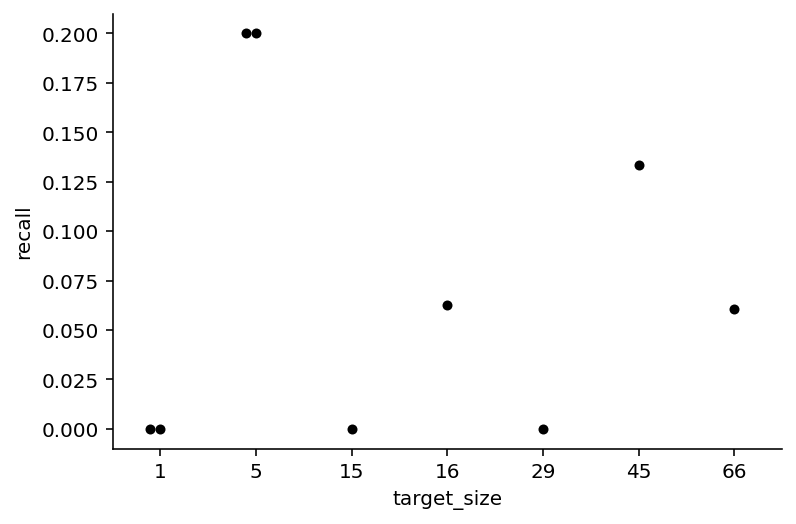

In [41]:
compare_df = _df.groupby('chemName')['GeneId'].apply(set).reset_index(name='experiment').merge(
    ai_df.groupby('chemName')['GeneId'].apply(set).reset_index(name='ai_dock'), on='chemName', how='left'
)
def f(x): return(len(x[1] & x[2])/len(x[1]))
compare_df['recall'] = compare_df.apply(f, axis=1)

compare_df['target_size'] = compare_df.experiment.apply(lambda x: len(x))
sns.swarmplot(data=compare_df, x='target_size', y='recall', color='black')
sns.despine()

Recall is low and according to [this](https://pubmed.ncbi.nlm.nih.gov/27104528/#:~:text=Despite%20their%20unquestionable%20merits%2C%20docking,simple%20scoring%20functions%20they%20use.) study, predicted affinities with autodocking is not accurate when rescoring process is not perfomred. I am not comfortable to move on with the provided interactions. 

In [42]:
ai_df[['chemName', 'chemId', 'GeneId']].drop_duplicates().to_csv('data/chemical_target_autodock.csv', index=False)

### ChEMBL ligand-protein predictions

ChEMBL's web service for target prediction is deprecated (here is [announcement](http://chembl.blogspot.com/2020/03/chembl-26-released.html)). I took the following list from the website that only shows 352 top predictions!  

In [36]:
path = '/Users/f.nasirian/Dropbox (CCNR)/Biology/99_Toolbox/data/'
col = ['uniprotId', 'targetId', 'targetName', 'targetType']
uni = pd.read_csv(path+'ChEMBL/data/raw/chembl_uniprot_mapping.txt', sep='\t', header=None, names=col).drop('targetName', axis=1)
uni['targetType'] = uni.targetType.str.lower()
uni.head(1)

,uniprotId,targetId,targetType
0,P21266,CHEMBL2242,single protein


In [37]:
chembl_pred = pd.read_csv('data/chemical_target_chembl_pred.csv')
chembl_pred = chembl_pred[(chembl_pred.Organism == 'Homo sapiens') &
 (chembl_pred.Confidence_90 == 'active') & (chembl_pred.Activity_thr >= 6)].rename(columns={'Target': 'targetId'})
chembl_pred = chembl_pred.merge(uni, on='targetId', how='left')

In [38]:
uni = pd.read_csv(path+'gene_annotations/data/out/uniprot_symbol_v1.csv')
uni = uni[uni.organismId == 9606]
chembl_pred = chembl_pred.merge(uni[['uniprotId', 'symbol']],
 on='uniprotId', how='left').rename(columns={'symbol': 'GeneId'})

In [40]:
chembl_pred['chemName'] = chembl_pred.ChemId.apply(lambda x: id_name[x])

In [41]:
#chemical-target count
chembl_pred.groupby('chemName')['GeneId'].size() 

chemName
Ascorbic acid       3
Chebulinic acid    28
Citric acid         1
Corilagin          28
Ellagic acid        6
Gallic acid         3
Geraniin           37
Kaempferol          5
Pedunculagin       29
Pyrogallol          1
Quercetin          10
Name: GeneId, dtype: int64

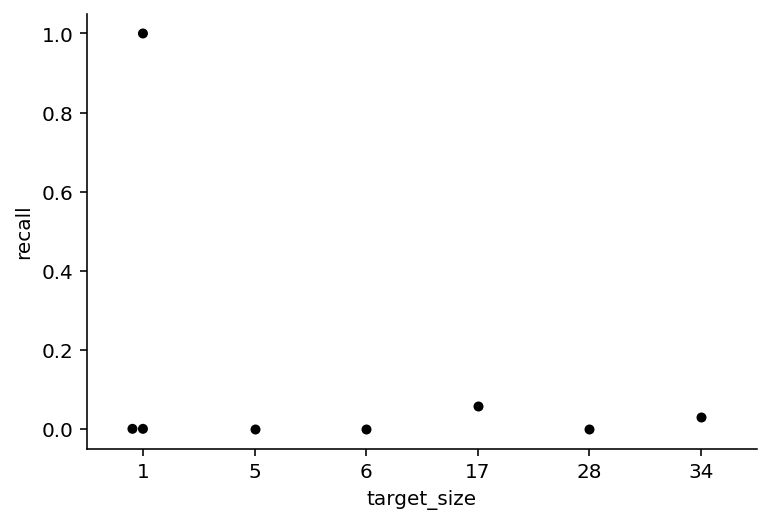

In [54]:
compare_df = _df.groupby('chemName')['GeneId'].apply(set).reset_index(name='experiment').merge(
    chembl_pred.groupby('chemName')['GeneId'].apply(set).reset_index(name='chembl_pred'), on='chemName', how='left'
)
def f(x): return(len(x[1] & x[2])/len(x[1]))
compare_df['recall'] = compare_df.apply(f, axis=1)

compare_df['target_size'] = compare_df.experiment.apply(lambda x: len(x))
sns.swarmplot(data=compare_df, x='target_size', y='recall', color='black')
sns.despine()